In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
from tqdm import tqdm

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import data_quality_checks

In [4]:
def cogs_analysis(df_in:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
        df_sales['week'] = df_sales['sales_datetime'].dt.strftime("%W")
    # total # of trxns
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxn by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage']]
    
    return df_summary_simp,df_cogs_average_product




In [5]:
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'
CURRENT_MONTH = '2022-02'

In [6]:
ca_df = pd.read_csv('cali_comp.csv',index_col = 0)
ca_df.columns = ['company_name','company_identifier','state','licenses']
ca_df['company_identifier'] = ca_df['company_identifier'].astype(str)

In [7]:
ca_df_clean = ca_df[~ca_df['company_identifier'].isin(['PL','WHT','GF','UR'])]
ca_df_clean.shape

(42, 4)

In [8]:
ca_df_clean['company_identifier'].unique()

array(['99HT', 'BUD', 'CG', 'CPA', 'CPC', 'CSC', 'CCC', 'CC', 'DGG', 'EL',
       'EMA', 'EMF', 'EMM', 'EMT', 'GT', 'GRG', 'GHC', 'HB', 'HPCC', 'HC',
       'IDC', 'LBC', 'ML', 'MW', 'MPW', 'MD', 'ND', 'PRP', 'PRL', 'RA',
       'RGD', 'SFV', 'SV', 'SLCC', 'SO', 'ST', 'TGL', 'TJR', 'TT', 'T4L',
       'UHHC', 'VOY'], dtype=object)

In [9]:
def calculate_ca_gmv_change(company_identifier,transfer_packages_start_date,sales_transactrions_start_date,current_month):
    # setup
    df_summary_simp_list = {}
    quality_metric_list = list()
    # read data
    df_in,df_sales_deduped,bad_dl,unknown_transfer,rwp,miss_incoming,miss_receipts = data_quality_checks.run(company_identifier,transfer_packages_start_date,sales_transactrions_start_date)    
    licenses = df_sales_deduped['license_number'].unique()
    # loop thru locations
    for l in tqdm(licenses):
        print(l)
        df_in_l = df_in[df_in['license_number'] == l]
        df_sales_deduped_l = df_sales_deduped[df_sales_deduped['license_number'] == l]
        df_in_l['per_unit_incoming'] = df_in_l['shipper_wholesale_price'] / df_in_l['shipped_quantity']
        df_in_l = df_in_l[df_in_l['per_unit_incoming'] <= 10000]
        df_sales_l = df_sales_deduped_l
        df_summary_simp,df_cogs_average_product = cogs_analysis(df_in_l,df_sales_l,'monthly')
        df_summary_simp.index = df_summary_simp.date 
        # tax treatment
        df_summary_simp['revenue_after_tax'] = df_summary_simp['revenue'] * 1.15
        df_summary_simp['cogs_after_tax'] = df_summary_simp['cogs'] * 1.27
        df_summary_simp['margin_$_after_tax'] = df_summary_simp['revenue_after_tax'] - df_summary_simp['cogs_after_tax']
        df_summary_simp['margin_%_after_tax'] = df_summary_simp['margin_$_after_tax'] / df_summary_simp['revenue_after_tax']
        
        #revenue change
        df_summary_simp['revenue_change'] = df_summary_simp['revenue'].pct_change()
        df_summary_simp['revenue_change_after_tax'] = df_summary_simp['revenue_after_tax'].pct_change()
        
        #rolling gm
        df_summary_simp['gm_past_quarter_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(3).mean().values
        df_summary_simp['gm_past_2quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(6).mean().values
        df_summary_simp['gm_past_3quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(9).mean().values
            
        df_summary_simp_list[l] = df_summary_simp
            
    quality_metric_list.append(list([bad_dl,unknown_transfer,rwp,miss_incoming,miss_receipts]))       
    return df_summary_simp_list,quality_metric_list
    

In [10]:
def get_ca_gmv_change_bm_list(company_list,transfer_packages_start_date,sales_transactrions_start_date,current_month):
    cogs_df_list = {}
    quality_metric_list = {}
    for c in tqdm(company_list):
        print(c)
        cogs_df,quality_metric = calculate_ca_gmv_change([c],transfer_packages_start_date,sales_transactrions_start_date,current_month)
        cogs_df_list[c] = cogs_df
        quality_metric_list[c] = quality_metric
    return cogs_df_list,quality_metric_list
    
    

In [ ]:
#test out
#a,b = get_ca_gmv_change_bm_list(list(ca_df_clean['company_identifier'])[0:2],TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,CURRENT_MONTH)


In [ ]:
#b['CPA']['C9-0000348-LIC']

# run

In [ ]:
# no PL, WHT
# no GF (bad download history)
#UR: Data too big???

In [11]:
ca_cogs_df_list,ca_quality_metric_list = get_ca_gmv_change_bm_list(list(ca_df_clean['company_identifier']),TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,CURRENT_MONTH)


  0%|          | 0/42 [00:00<?, ?it/s]

99HT
Verifying download summaries for license C10-0000279-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
93.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 8164 (8.105719874105183%)
# transactions total: 100719
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 46637



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000279-LIC



  2%|▏         | 1/42 [00:30<20:52, 30.54s/it]

BUD
Verifying download summaries for license C9-0000167-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

Verifying download summaries for license C9-0000399-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

Verifying download summaries for license C9-0000444-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

Verifying download summaries for license C9-0000464-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

Verifying download summaries for license C9-0000467-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-24

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
85.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 65133 (18.385856555711126%)
# transactions total: 354256
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing


  0%|          | 0/5 [00:00<?, ?it/s]

C9-0000464-LIC



 20%|██        | 1/5 [00:00<00:02,  1.69it/s]

C9-0000467-LIC



 40%|████      | 2/5 [00:00<00:01,  2.27it/s]

C9-0000399-LIC



 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

C9-0000444-LIC



 80%|████████  | 4/5 [00:01<00:00,  2.25it/s]

C9-0000167-LIC



  5%|▍         | 2/42 [01:24<29:34, 44.37s/it]

CG
Verifying download summaries for license C9-0000157-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
95.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 257 (1.2484212571650637%)
# transactions total: 20586
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 11324



100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

C9-0000157-LIC



  7%|▋         | 3/42 [01:49<22:55, 35.27s/it]

CPA
Verifying download summaries for license CCL19-0004859...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003278...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C9-0000348-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000461-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000844-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
91.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 5976 (1.496862750009393%)
# transactions total: 399235
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing t


  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000461-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.61s/it]

C9-0000348-LIC



 10%|▉         | 4/42 [02:47<28:09, 44.47s/it]

CPC
Verifying download summaries for license C9-0000056-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-01

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
96.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 513 (0.8194102801648404%)
# transactions total: 62606
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 38338



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000056-LIC



 12%|█▏        | 5/42 [03:12<23:04, 37.41s/it]

CSC
Verifying download summaries for license C10-0000670-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000918-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 247869
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 17 (0.012575173648353763%)
# receipts total: 135187



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000670-LIC



100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


C10-0000918-LIC


 14%|█▍        | 6/42 [03:54<23:24, 39.02s/it]

CCC
Verifying download summaries for license C12-0000087-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07
Found bad download summary for license C12-0000087-LIC on date 2022-02-20

[FAILURE] Found a total of 1 bad download summaries
[SUCCESS] No unknown transfer packages!
86.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 16420 (5.069262425404352%)
# transactions total: 323913
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 5 (0.0026679472813617203%)
# receipts total: 187410



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000087-LIC



 17%|█▋        | 7/42 [04:45<25:00, 42.88s/it]

CC
Verifying download summaries for license C10-0000758-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 27658
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 1 (0.005955571437079388%)
# receipts total: 16791



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000758-LIC



 19%|█▉        | 8/42 [05:08<20:41, 36.52s/it]

DGG
Verifying download summaries for license C9-0000016-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07
Found bad download summary for license C9-0000016-LIC on date 2022-02-22

[FAILURE] Found a total of 1 bad download summaries
[SUCCESS] No unknown transfer packages!
94.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 1599 (4.540420819490587%)
# transactions total: 35217
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 15616



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000016-LIC



 21%|██▏       | 9/42 [05:32<17:55, 32.58s/it]

EL
Verifying download summaries for license C9-0000370-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 20137
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 7874



 24%|██▍       | 10/42 [05:53<15:31, 29.12s/it]

C9-0000370-LIC
EMA
Verifying download summaries for license C10-0000774-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000695-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-02-09

Verifying download summaries for license C10-0000786-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-02-09

Verifying download summaries for license C10-0000939-LIC...
Earliest download summary: 2022-01-25
Latest download summary: 2022-02-09

[SUCCESS] All download summaries look good!
[FAILURE] Fxound a total of 42 unknown transfer packages
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 105088
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 46533



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000774-LIC



 26%|██▌       | 11/42 [06:22<14:57, 28.97s/it]

EMF
Verifying download summaries for license C10-0000939-LIC...
Earliest download summary: 2021-10-01
Latest download summary: 2022-03-07
Found bad download summary for license C10-0000939-LIC on date 2022-02-20

[FAILURE] Found a total of 1 bad download summaries
[SUCCESS] No unknown transfer packages!
95.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 5740
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 2310



 29%|██▊       | 12/42 [06:42<13:05, 26.18s/it]

C10-0000939-LIC
EMM
Verifying download summaries for license C10-0000786-LIC...
Earliest download summary: 2022-02-07
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 121349
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 57530



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000786-LIC



 31%|███       | 13/42 [07:12<13:19, 27.58s/it]

EMT
Verifying download summaries for license C10-0000695-LIC...
Earliest download summary: 2022-02-07
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 231149
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 108522



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000695-LIC



 33%|███▎      | 14/42 [07:52<14:32, 31.17s/it]

GT
Verifying download summaries for license CDPH-10004633...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C9-0000170-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07
Found bad download summary for license C9-0000170-LIC on date 2022-02-20

Verifying download summaries for license C9-0000385-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07
Found bad download summary for license C9-0000385-LIC on date 2022-02-20

Verifying download summaries for license C11-0001267-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[FAILURE] Found a total of 2 bad download summaries
[SUCCESS] No unknown transfer packages!
27.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 326 (0.3116158140246234%)
# transactions total: 104616
# receipts with mismatching transactions: 0 (0.0%)
#


  0%|          | 0/2 [00:00<?, ?it/s]

C9-0000385-LIC



 36%|███▌      | 15/42 [08:21<13:45, 30.57s/it]

C9-0000170-LIC
GRG
Verifying download summaries for license C10-0000169-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000408-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
96.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 3959 (0.6392660147520443%)
# transactions total: 619304
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 313171



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000408-LIC



 50%|█████     | 1/2 [00:01<00:01,  1.36s/it]

C10-0000169-LIC



 38%|███▊      | 16/42 [09:34<18:45, 43.28s/it]

GHC
Verifying download summaries for license CCL18-0000591...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003269...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000414-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000985-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 12836 (6.29175591751506%)
# transactions total: 204013
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 105978



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000414-LIC



 40%|████      | 17/42 [10:10<17:07, 41.10s/it]

HB
Verifying download summaries for license CCL19-0004924...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003642...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000301-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000339-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000624-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000571-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
66.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer 


  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000624-LIC



 33%|███▎      | 1/3 [00:01<00:03,  1.83s/it]

C10-0000339-LIC



100%|██████████| 3/3 [00:05<00:00,  1.93s/it]

C10-0000301-LIC



 43%|████▎     | 18/42 [11:26<20:38, 51.61s/it]

HPCC
Verifying download summaries for license C10-0000005-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000064-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 21908 (1.7259757458967895%)
# transactions total: 1269311
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 579505



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000064-LIC



 50%|█████     | 1/2 [00:12<00:12, 12.59s/it]

C10-0000005-LIC



 45%|████▌     | 19/42 [14:19<33:48, 88.21s/it]

HC
Verifying download summaries for license C9-0000341-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
92.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 12695
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 6898



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000341-LIC


 48%|████▊     | 20/42 [14:41<25:01, 68.25s/it]

IDC
Verifying download summaries for license C9-0000320-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
95.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 113980
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 62069



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000320-LIC



 50%|█████     | 21/42 [15:11<19:52, 56.78s/it]

LBC
Verifying download summaries for license C9-0000154-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
93.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 310 (1.14441819255759%)
# transactions total: 27088
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 8505



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000154-LIC



 52%|█████▏    | 22/42 [15:33<15:26, 46.33s/it]

ML
Verifying download summaries for license C9-0000300-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
96.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 122188
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 8 (0.01754616835548537%)
# receipts total: 45594



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000300-LIC



 55%|█████▍    | 23/42 [16:08<13:32, 42.76s/it]

MW
Verifying download summaries for license C10-0000332-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 4176 (1.2446759997496342%)
# transactions total: 335509
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 16 (0.009274448315238498%)
# receipts total: 172517



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000332-LIC



 57%|█████▋    | 24/42 [16:57<13:28, 44.91s/it]

MPW
Verifying download summaries for license C10-0000547-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 125 (0.029255232005691897%)
# transactions total: 427274
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 125 (0.06545462161992334%)
# receipts total: 190972



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000547-LIC



 60%|█████▉    | 25/42 [17:56<13:50, 48.85s/it]

MD
Verifying download summaries for license C9-0000247-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 2249 (3.197781885397412%)
# transactions total: 70330
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 25501



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000247-LIC



 62%|██████▏   | 26/42 [18:22<11:12, 42.03s/it]

ND
Verifying download summaries for license C9-0000427-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
70.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 13134
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 3966



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000427-LIC



 64%|██████▍   | 27/42 [18:42<08:50, 35.39s/it]

PRP
Verifying download summaries for license C10-0000155-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000286-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000403-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000759-LIC...
Earliest download summary: 2022-02-05
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[FAILURE] Fxound a total of 788 unknown transfer packages
94.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 44421 (5.940407367437083%)
# transactions total: 747777
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 315684



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000403-LIC



 33%|███▎      | 1/3 [00:02<00:05,  2.81s/it]

C10-0000286-LIC



 67%|██████▋   | 2/3 [00:04<00:02,  2.38s/it]

C10-0000155-LIC



 67%|██████▋   | 28/42 [20:04<11:32, 49.46s/it]

PRL
Verifying download summaries for license C10-0000759-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-02-06

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
93.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 16054 (5.73812093874429%)
# transactions total: 279778
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 1 (0.0009451349180095459%)
# receipts total: 105805



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000759-LIC



 69%|██████▉   | 29/42 [20:47<10:18, 47.59s/it]

RA
Verifying download summaries for license C10-0000596-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
95.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 132604
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 4 (0.006188789008710721%)
# receipts total: 64633



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000596-LIC



 71%|███████▏  | 30/42 [21:21<08:41, 43.48s/it]

RGD
Verifying download summaries for license C9-0000057-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
96.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 51904
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 31001



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000057-LIC



 74%|███████▍  | 31/42 [21:46<06:58, 38.05s/it]

SFV
Verifying download summaries for license CCL18-0001788...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003406...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000041-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000323-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
93.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 14947 (3.131684975161487%)
# transactions total: 477283
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 3 (0.0010098358006988065%)
# receipts total: 297078



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000041-LIC



 76%|███████▌  | 32/42 [22:47<07:29, 44.95s/it]

SV
Verifying download summaries for license C9-0000146-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
97.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 10333 (8.255172964767915%)
# transactions total: 125170
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 8 (0.02170492159097075%)
# receipts total: 36858



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000146-LIC



 79%|███████▊  | 33/42 [23:18<06:05, 40.65s/it]

SLCC
Verifying download summaries for license C10-0000474-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
99.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 6223 (11.8454363757495%)
# transactions total: 52535
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 24098



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000474-LIC



 81%|████████  | 34/42 [23:43<04:46, 35.87s/it]

SO
Verifying download summaries for license CCL19-0000839...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license CCL19-0004425...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license C9-0000130-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license C10-0000271-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license C11-0000020-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

Verifying download summaries for license C12-0000328-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2021-12-22

[SUCCESS] All download summaries look good!
[FAILURE] Fxound a total of 234 unknown transfer packages
85.0% of incoming transfer packages have receiver wholesale price
# transactions missing i


  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000271-LIC



 50%|█████     | 1/2 [00:01<00:01,  1.11s/it]

C9-0000130-LIC



 83%|████████▎ | 35/42 [24:22<04:18, 36.89s/it]

ST
Verifying download summaries for license C9-0000323-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C12-0000359-LIC...
Earliest download summary: 2022-01-03
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
99.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 540 (0.5350083718902638%)
# transactions total: 100933
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 48339



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000323-LIC



 86%|████████▌ | 36/42 [24:50<03:25, 34.22s/it]

TGL
Verifying download summaries for license C9-0000412-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07
Found bad download summary for license C9-0000412-LIC on date 2021-12-29

[FAILURE] Found a total of 1 bad download summaries
[SUCCESS] No unknown transfer packages!
99.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 4322
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 1650



 88%|████████▊ | 37/42 [25:09<02:27, 29.58s/it]

C9-0000412-LIC
TJR
Verifying download summaries for license C9-0000105-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
99.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 98602 (24.0551940843964%)
# transactions total: 409899
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 33288



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000105-LIC



 90%|█████████ | 38/42 [26:13<02:40, 40.06s/it]

TT
Verifying download summaries for license C9-0000451-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0001391-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
77.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 112841
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 47989



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000451-LIC



 93%|█████████▎| 39/42 [26:42<01:50, 36.71s/it]

T4L
Verifying download summaries for license C12-0000302-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
86.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 229 (1.4585987261146496%)
# transactions total: 15700
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 7624



 95%|█████████▌| 40/42 [27:04<01:04, 32.32s/it]

C12-0000302-LIC
UHHC
Verifying download summaries for license CCL19-0004871...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003448...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license CDPH-10003451...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C9-0000082-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000817-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C10-0000827-LIC...
Earliest download summary: 2021-12-26
Latest download summary: 2022-03-07

Verifying download summaries for license C11-0000313-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look goo


  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000817-LIC
C9-0000082-LIC



 98%|█████████▊| 41/42 [27:35<00:31, 31.74s/it]

VOY
Verifying download summaries for license C10-0000802-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C12-0000030-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C12-0000159-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

Verifying download summaries for license C12-0000175-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-07

[SUCCESS] All download summaries look good!
[FAILURE] Fxound a total of 13730 unknown transfer packages
15.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 4817
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 1983



100%|██████████| 42/42 [27:59<00:00, 39.99s/it]

C10-0000802-LIC


In [12]:
ca_cogs_df_list.keys()

dict_keys(['99HT', 'BUD', 'CG', 'CPA', 'CPC', 'CSC', 'CCC', 'CC', 'DGG', 'EL', 'EMA', 'EMF', 'EMM', 'EMT', 'GT', 'GRG', 'GHC', 'HB', 'HPCC', 'HC', 'IDC', 'LBC', 'ML', 'MW', 'MPW', 'MD', 'ND', 'PRP', 'PRL', 'RA', 'RGD', 'SFV', 'SV', 'SLCC', 'SO', 'ST', 'TGL', 'TJR', 'TT', 'T4L', 'UHHC', 'VOY'])

# output data

In [13]:
df = pd.DataFrame()
for k in ca_cogs_df_list.keys():
    print(k)
    for l in ca_cogs_df_list[k].keys():
        print(l)
        data = ca_cogs_df_list[k][l]
        data['company'] = k
        data['location'] = l
        print(data.shape)
        df = df.append(data)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(15, 20)
BUD
C9-0000464-LIC
(5, 20)
C9-0000467-LIC
(4, 20)
C9-0000399-LIC
(12, 20)
C9-0000444-LIC
(4, 20)
C9-0000167-LIC
(11, 20)
CG
C9-0000157-LIC
(25, 20)
CPA
C10-0000461-LIC
(26, 20)
C9-0000348-LIC
(16, 20)
CPC
C9-0000056-LIC
(19, 20)
CSC
C10-0000670-LIC
(27, 20)
C10-0000918-LIC
(4, 20)
CCC
C12-0000087-LIC
(27, 20)
CC
C10-0000758-LIC
(13, 20)
DGG
C9-0000016-LIC
(27, 20)
EL
C9-0000370-LIC
(19, 20)
EMA
C10-0000774-LIC
(15, 20)
EMF
C10-0000939-LIC
(2, 20)
EMM
C10-0000786-LIC
(13, 20)
EMT
C10-0000695-LIC
(22, 20)
GT
C9-0000385-LIC
(5, 20)
C9-0000170-LIC
(9, 20)
GRG
C10-0000408-LIC
(8, 20)
C10-0000169-LIC
(27, 20)
GHC
C10-0000414-LIC
(17, 20)
HB
C10-0000624-LIC
(27, 20)
C10-0000339-LIC
(27, 20)
C10-0000301-LIC
(20, 20)
HPCC
C10-0000064-LIC
(27, 20)
C10-0000005-LIC
(27, 20)
HC
C9-0000341-LIC
(13, 20)
IDC
C9-0000320-LIC
(24, 20)
LBC
C9-0000154-LIC
(23, 20)
ML
C9-0000300-LIC
(21, 20)
MW
C10-0000332-LIC
(27, 20)
MPW
C10-0000547-LIC
(21, 20)
MD
C9-0000247-LIC
(27, 20)
ND


In [14]:
df.to_csv('ca_analysis_0307.csv')

In [ ]:
#df.to_excel('ca_location_analysis/'+'ca_analysis.xlsx')

In [15]:
df

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,revenue_change,revenue_change_after_tax,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,company,location
date,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,291646.25,69941.447555,221704.802445,0.760184,4808.0,2003.0,2805,0.696005,335393.1875,88825.638395,246567.549105,0.735160,NaN,NaN,NaN,NaN,NaN,99HT,C10-0000279-LIC
2021-02,2021-02,262906.73,85322.341897,177584.388103,0.675465,5464.0,377.0,5087,0.948611,302342.7395,108359.374209,193983.365291,0.641601,-0.098542,-0.098542,NaN,NaN,NaN,99HT,C10-0000279-LIC
2021-03,2021-03,315154.72,99950.244014,215204.475986,0.682853,6902.0,159.0,6743,0.951475,362427.9280,126936.809898,235491.118102,0.649760,0.198732,0.198732,0.675507,NaN,NaN,99HT,C10-0000279-LIC
2021-04,2021-04,329925.48,100937.302787,228988.177213,0.694060,7081.0,112.0,6969,0.931465,379414.3020,128190.374539,251223.927461,0.662136,0.046868,0.046868,0.651166,NaN,NaN,99HT,C10-0000279-LIC
2021-05,2021-05,336793.80,99047.578798,237746.221202,0.705910,7286.0,131.0,7155,0.918326,387312.8700,125790.425074,261522.444926,0.675223,0.020818,0.020818,0.662373,NaN,NaN,99HT,C10-0000279-LIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11,2021-11,18761.21,5470.325953,13290.884047,0.708424,610.0,52.0,558,0.884058,21575.3915,6947.313960,14628.077540,0.677998,0.111837,0.111837,0.591387,NaN,NaN,VOY,C10-0000802-LIC
2021-12,2021-12,32715.38,12198.903894,20516.476106,0.627120,1062.0,129.0,933,0.919481,37622.6870,15492.607945,22130.079055,0.588211,0.743778,0.743778,0.644411,NaN,NaN,VOY,C10-0000802-LIC
2022-01,2022-01,24339.01,11123.403847,13215.606153,0.542980,831.0,43.0,788,0.936866,27989.8615,14126.722885,13863.138615,0.495291,-0.256038,-0.256038,0.587167,NaN,NaN,VOY,C10-0000802-LIC


In [16]:
df['id'] = list(zip(df.company, df.location))

In [17]:
df = df.reset_index(drop = True)

In [18]:
orig_gm_past_3m = df[df['gm_past_quarter_after_tax'] > 0][['id','date']].groupby(['date']).count()
orig_gm_dolloar = df[df['gm_past_quarter_after_tax'] > 0][['margin_$_after_tax','date']].groupby(['date']).mean()
for i in numpy.arange(0.4, 0.61, 0.01):
    print(round(i,2))
    qualify = df[df['gm_past_quarter_after_tax'] > i]
    to_join = qualify[['id','date']].groupby(['date']).count()
    to_join_med_margin_dolloar = qualify[['margin_$_after_tax','date']].groupby(['date']).mean()
    to_join.columns = [str(round(i,2))]
    to_join_med_margin_dolloar.columns = [str(round(i,2))]
    orig_gm_past_3m = pd.concat([orig_gm_past_3m,to_join],axis = 1,join = 'outer')
    orig_gm_dolloar = pd.concat([orig_gm_dolloar,to_join_med_margin_dolloar],axis = 1,join = 'outer')

0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6


In [19]:
orig_gm_past_3m

,id,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6
date,,,,,,,,,,,,,,,,,,,,,,
2020-03,15,14,14,14,14,14,13,13,13,13,12,12,11,11,11,10,10,10,10,10,10,10
2020-04,17,16,16,16,15,15,15,14,14,14,13,13,12,11,11,11,10,9,8,6,6,6
2020-05,19,17,17,17,17,17,16,16,15,13,13,11,11,10,9,8,6,5,5,5,5,5
2020-06,20,17,17,17,16,16,16,15,15,14,13,11,9,9,8,6,5,5,5,5,5,5
2020-07,22,18,17,17,17,17,17,16,16,15,11,11,10,10,9,8,8,5,5,5,5,5
2020-08,23,19,18,18,17,17,17,17,14,13,11,10,10,10,10,8,8,7,6,6,6,5
2020-09,26,21,21,19,19,18,18,17,15,14,13,10,10,10,10,9,9,6,6,6,5,5
2020-10,27,22,22,20,20,20,20,19,17,17,15,14,14,13,13,11,10,9,8,8,7,7
2020-11,28,25,24,23,22,22,22,21,18,16,16,16,16,16,13,12,10,10,9,8,6,6


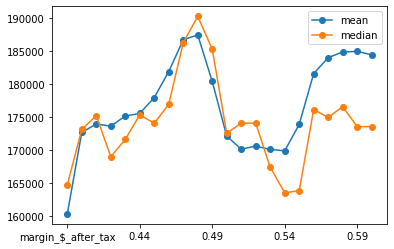

In [20]:
orig_gm_dolloar.mean(axis = 0).plot(marker = 'o',label = 'mean')
orig_gm_dolloar.median(axis = 0).plot(marker = 'o',label = 'median')
plt.legend()

In [ ]:
orig_gm_dolloar['0.48'].plot()
orig_gm_dolloar['0.55'].plot()
plt.legend()

In [ ]:
orig_gm_dolloar

In [ ]:
df.head()

In [21]:
orig_gm_past_6m = df[df['gm_past_2quarters_after_tax'] > 0][['id','date']].groupby(['date']).count()
for i in numpy.arange(0.4, 0.61, 0.01):
    print(round(i,2))
    qualify = df[df['gm_past_2quarters_after_tax'] > i]
    to_join = qualify[['id','date']].groupby(['date']).count()
    to_join.columns = [str(round(i,2))]
    orig_gm_past_6m = pd.concat([orig_gm_past_6m,to_join],axis = 1,join = 'outer')

0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6


In [22]:
orig_gm_past_6m

,id,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6
date,,,,,,,,,,,,,,,,,,,,,,
2020-06,15,13,13,13,13,13,13,13,13,13,11,11,11,10,10,10,9,9,8,7,6,4
2020-07,17,15,15,15,15,15,15,15,14,12,11,10,9,9,8,7,7,5,5,5,5,5
2020-08,18,15,15,14,14,14,14,14,13,12,10,9,9,9,9,7,6,5,5,4,4,4
2020-09,20,16,16,16,16,15,15,15,14,14,11,10,9,8,7,7,5,4,4,4,4,4
2020-10,22,19,18,18,17,17,16,16,14,13,11,11,10,10,10,9,7,5,5,5,5,5
2020-11,23,20,19,17,17,17,16,16,14,13,13,13,12,12,11,11,8,7,7,7,6,5
2020-12,26,22,21,21,20,19,18,16,14,13,13,12,12,12,12,10,8,8,8,8,6,6
2021-01,27,24,22,21,21,21,19,18,16,16,15,14,14,14,12,11,10,8,8,8,7,6
2021-02,28,23,23,22,22,22,22,21,18,17,17,17,15,14,12,12,10,10,9,9,8,8


In [23]:
orig_gm_past_9m = df[df['gm_past_3quarters_after_tax'] > 0][['id','date']].groupby(['date']).count()
for i in numpy.arange(0.4, 0.61, 0.01):
    print(round(i,2))
    qualify = df[df['gm_past_3quarters_after_tax'] > i]
    to_join = qualify[['id','date']].groupby(['date']).count()
    to_join.columns = [str(round(i,2))]
    orig_gm_past_9m = pd.concat([orig_gm_past_9m,to_join],axis = 1,join = 'outer')

0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6


In [24]:
orig_gm_past_9m

,id,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6
date,,,,,,,,,,,,,,,,,,,,,,
2020-09,15,13,13,13,13,13,13,13,13,11,10,10,8,8,8,8,8,6,5,4,4,3
2020-10,17,15,15,15,15,15,14,14,12,12,12,12,11,8,8,7,6,4,4,4,4,4
2020-11,19,16,16,16,16,16,16,15,13,13,12,10,10,10,10,7,5,4,4,4,4,4
2020-12,21,17,17,17,17,17,17,16,14,12,11,10,10,10,9,8,6,6,6,5,5,5
2021-01,23,21,19,17,17,17,17,17,14,13,13,11,11,11,10,9,7,7,7,7,6,6
2021-02,24,20,19,19,19,19,19,19,15,14,14,14,13,12,11,10,8,8,7,7,6,6
2021-03,26,23,22,21,20,19,19,18,16,15,15,14,14,14,12,9,7,7,7,7,6,6
2021-04,27,23,22,22,21,21,21,20,16,16,16,16,15,14,12,11,10,9,9,9,7,7
2021-05,28,24,23,23,23,22,22,19,17,17,17,17,16,14,13,12,11,11,11,10,9,8


# rev change

In [ ]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [ ]:
rev_change = flatten_list(ca_gmv_change_list)

In [ ]:
rev_change_df = pd.DataFrame(ca_gmv_change_list)
rev_change_df['company'] = ca_cogs_df_list.keys()

In [ ]:
df